In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
import gensim
import dexplot as dxp
from collections import Counter
from matplotlib import rcParams
from gensim import corpora, models, similarities
from itertools import chain
from sklearn.cluster import MeanShift

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None) 

In [3]:
cd desktop

C:\Users\VIJESH\desktop


In [4]:
data=pd.read_csv("processed_reviews_practo.csv") #importing the processed reviews

In [5]:
data.head()

,reviews,recommendation,location,text_clean,sentiment,reviews_stop_words,reviews_stop_words_1
0,This doctor is so to the point and focused and she asked all the right questions right from the go. Her tone is very accommodating. I am impressed.,I recommend the doctor,Bangalore,This doctor point focus ask right question right go Her tone accommodate I impress,Positive,doctor point focus ask right question right go tone accommodate impress,point focus ask right question right go tone accommodate impress
1,*** ** *** **** ****** ** ********** ***** She explains the issue in our body and tells us how to solve it rather than just prescribing medicine. I recommend her,I recommend the doctor,Bangalore,She explain issue body tell solve rather prescribe medicine I recommend,Positive,explain issue body tell solve rather prescribe medicine recommend,explain issue body tell solve rather prescribe medicine
2,Doctor listened very patiently and explained everything. She advised me medicine. I got little releif. But overall my experience is good with doctor. Thanks Doctor,I recommend the doctor,Bangalore,Doctor listen patiently explain everything She advise medicine I get little releif But overall experience good doctor Thanks Doctor,Positive,doctor listen patiently explain everything advise medicine get little releif overall experience good doctor thanks doctor,listen patiently explain everything advise medicine get little releif overall thanks
3,such a wonderfull doctor who explains clearly *** *** **** * ***** **********I am perfectly alright now ..😊,I recommend the doctor,Bangalore,wonderfull doctor explain clearly I perfectly alright 😊,Positive,wonderfull doctor explain clearly perfectly alright 😊,wonderfull explain clearly perfectly alright 😊
4,Even after booking through practo we had to wait for other patients and they charged extra on top of it. Seriously I don't understand the need of booking through practo . I would never recommend this app to anyone. It's better to go directly and save some money.,I do not recommend the doctor,Bangalore,Even book practo have wait patient charge extra top it Seriously I do n't understand need book practo I would never recommend app anyone It 's good go directly save money,Negative,even book practo wait patient charge extra top seriously donot understand need book practo would never recommend app anyone 's good go directly save money,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money


In [6]:
data=data.dropna(how='any') #dropping all missing reviews

In [7]:
len(data)

14651

## Distribution of recommendations

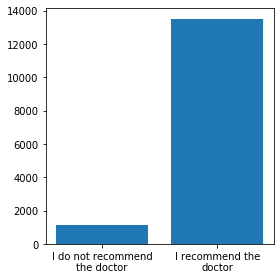

In [8]:
dxp.aggplot(agg="recommendation", data=data,figsize=(4, 4)) 

## Distribution of reviews on location

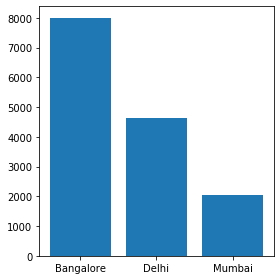

In [9]:
dxp.aggplot(agg="location", data=data,figsize=(4, 4))

## Function to extract sentiment from the reviews

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
  
    sentiment_dict = sid_obj.polarity_scores(str(sentence)) #finding polarity score
 
    if sentiment_dict['compound'] >= 0.05 :     #score is greater than 0.05 then the tweet is positive
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.05 : #score  less than -0.05 is negative
        return "Negative"
  
    else : 
        return "Neutral"

In [11]:
data['sentiment_vader']=data.apply(lambda row:sentiment_scores(row['reviews_stop_words_1']),axis=1) #calling function

## Recommendations vs reviews sentiment

In [12]:
data.groupby('sentiment_vader')['sentiment'].value_counts().unstack() 

sentiment,Negative,Positive
sentiment_vader,,
Negative,556,836
Neutral,163,1264
Positive,454,11378


In [13]:
positive_reviews=data.loc[data['sentiment']=='Positive','reviews_stop_words_1'].tolist()#list of positive reviews
negative_reviews=data.loc[data['sentiment']=='Negative','reviews_stop_words_1'].tolist()#list of negative reviews

# Recommended Reviews

## Function to get LDA topics

In [14]:
def topics(List):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer.fit(List)
    counts = count_vectorizer.transform(List).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=1)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,passes=10,alpha='auto',per_word_topics=True)
    return lda.print_topics()

## Most common words

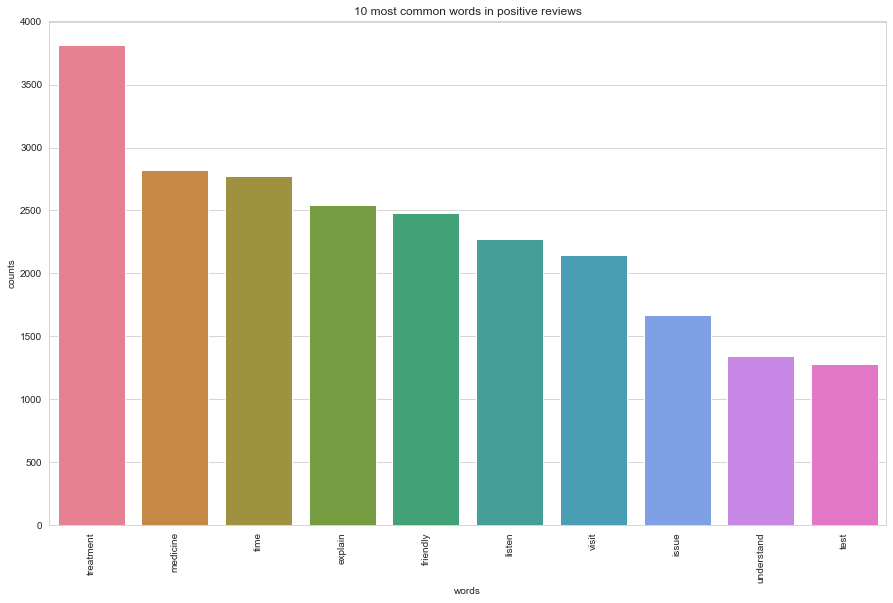

In [15]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    
    sns.set_style('whitegrid')
    %matplotlib inline
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words in positive reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(positive_reviews)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [16]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
medicine test visit day donot prescribe pain unnecessary fever medication time listen suffer suggest ask feel tell thank treatment year relief consult diagnose cough treat start month hospital check advise

Topic #1:
explain listen friendly time treatment issue understand medicine health patiently satisfy diagnosis highly make care visit great prescribe medication suggest carefully polite way family feel excellent nice advice professional cause

Topic #2:
diabetes control sugar treatment level explain blood diet diabetic report mother medication approach father year happy help suggest lifestyle change result come issue normal meet consult high thyroid family month

Topic #3:
treatment thank medicine treat result friendly thanks really happy way feel nice laxman god listen sir therapy best person disease great excellent family life bless nap jonwal health cure explain

Topic #4:
treatment clinic time visit staff nice wait friendly hospital appointment sa

In [17]:
topics(positive_reviews) #lda for recommended reviews

[(0,
  '0.021*"medicine" + 0.019*"treatment" + 0.019*"listen" + 0.018*"time" + 0.016*"prescribe" + 0.012*"explain" + 0.011*"day" + 0.010*"medication" + 0.009*"friendly" + 0.008*"visit"'),
 (1,
  '0.023*"medicine" + 0.022*"issue" + 0.020*"listen" + 0.013*"health" + 0.013*"explain" + 0.013*"treatment" + 0.012*"friendly" + 0.011*"visit" + 0.010*"time" + 0.010*"patiently"'),
 (2,
  '0.032*"treatment" + 0.027*"medicine" + 0.015*"listen" + 0.015*"visit" + 0.014*"explain" + 0.012*"time" + 0.009*"happy" + 0.008*"patiently" + 0.008*"friendly" + 0.008*"day"'),
 (3,
  '0.025*"treatment" + 0.017*"issue" + 0.013*"clinic" + 0.012*"really" + 0.009*"explain" + 0.009*"great" + 0.009*"treat" + 0.008*"health" + 0.008*"friendly" + 0.008*"advice"'),
 (4,
  '0.013*"treatment" + 0.011*"excellent" + 0.011*"explain" + 0.011*"thank" + 0.010*"make" + 0.009*"friendly" + 0.009*"treat" + 0.009*"visit" + 0.008*"family" + 0.008*"feel"'),
 (5,
  '0.032*"time" + 0.023*"friendly" + 0.020*"explain" + 0.018*"treatment" + 

## K-Means clustering for recommended reviews

In [18]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(positive_reviews)

lsa = TruncatedSVD(100, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

for cluster in range(5):
    features = order_centroids[cluster,0:5]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

medicine
prescribe
test
prescribe medicine
unnecessary


Cluster 1

listen
patiently
carefully
listen patiently
listen carefully


Cluster 2

explain
friendly
issue
time
friendly explain


Cluster 3

time
friendly
visit
understand
treat


Cluster 4

treatment
satisfy
satisfy treatment
happy
friendly




## Not recommended Reviews

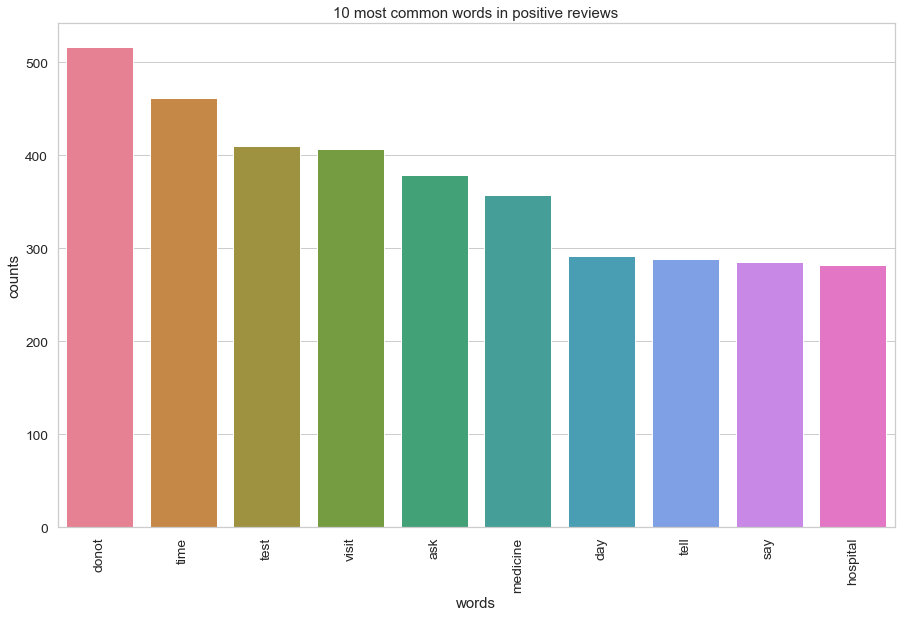

In [19]:
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(negative_reviews)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [20]:
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
time wait appointment donot visit ask clinic hour come tell hospital medicine book say consultation charge treatment test reach listen min practo minute 30 bad pay report staff 10 make

Topic #1:
charge visit ask time day donot consultation hospital rs tell fee say test report treatment blood admit need check pay available come bad high want health talk staff consult question

Topic #2:
medicine donot say prescribe visit listen ask day test report suggest tell consultation money clinic hospital explain time symptom rs busy charge bad infection urine consult make cough know need

Topic #3:
donot visit medicine explain issue say time ask day bad tell prescribe listen fee hospital consultation rude willnot doc come consult fever pain money question wife doctornot people treatment understand

Topic #4:
test fever day donot hospital ask report medicine prescribe blood check say tell visit time suggest pain come lab admit clinic treatment dengue typhoid money

## K-Means Clustering for not recommended reviews

In [21]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(negative_reviews)

lsa = TruncatedSVD(100, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

for cluster in range(5):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

charge
fee
consultation
visit
rs
consultation fee
high
time
mention
practo


Cluster 1

wait
appointment
time
hour
come
book
reach
wait hour
clinic
donot


Cluster 2

medicine
prescribe
donot
write
prescribe medicine
day
explain
visit
bad
clinic


Cluster 3

test
report
blood
fever
blood test
suggest
ask
tell
visit
day


Cluster 4

donot
visit
time
say
listen
ask
treatment
explain
bad
day




In [22]:
#recommended negative reviews
List_=data.loc[(data['sentiment']=='Positive')&(data['sentiment_vader']=='Negative'),'reviews_stop_words_1'].tolist()

In [23]:
#not recommended positive reviews
List=data.loc[(data['sentiment']=='Negative')&(data['sentiment_vader']=='Positive'),'reviews_stop_words_1'].tolist() 

In [24]:
len(List)

454

## Not recommended Positive reviews

In [25]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(List)

lsa = TruncatedSVD()
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=3, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape





for cluster in range(3):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

time
wait
appointment
donot
come
listen
visit
hour
ask
hospital


Cluster 1

donot
time
visit
test
medicine
ask
wait
say
tell
day


Cluster 2

test
medicine
visit
donot
report
day
prescribe
ask
tell
fever




In [26]:
X_dist = km.transform(lsa_vecs)**2

# do something useful...
import pandas as pd
df = pd.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])
df['label'] = km.labels_


df['reviews']=List
df.head()

,sqdist,label,reviews
0,1.75,0,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money
1,1.70,2,many medicine prescribe friendly
2,0.66,1,visited clinic wife fever vomit uma talk nicely treatment pathetic donot respond call treatment forgot mention one man army nurse front office staff see another next day sign improvement donot anyone
3,2.03,0,well mix response staff confuse overall response worry bill payment responsive however limit requirement seem ok doesnot probe much
4,1.90,0,general hygiene upkeep clinic improve make wait 30 minute confirm time phone fine bite awful staff support clinic avoid


## Function to create Bigrams

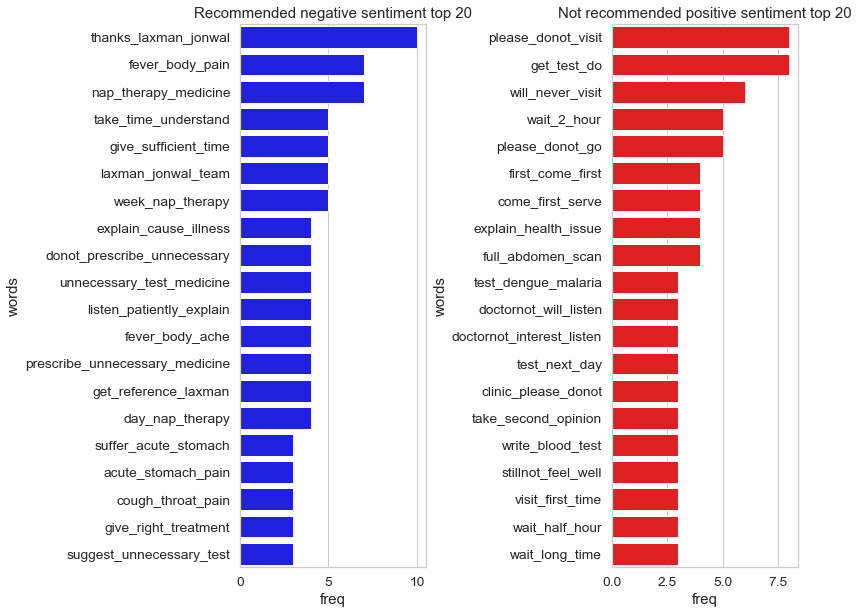

In [27]:
def commonwords(review,top):
    reviews=" ".join(review)
    tokenised_reviews=reviews.split(" ")
    
    
    freq_counter=Counter(tokenised_reviews) #counts the occurance
    return freq_counter.most_common(top)


recommended_negative_sentiment=commonwords(List_,30) #top 30 positive reviews
Not_recommended_positive_sentiment=commonwords(List,30) #top 30 negative reviews

def plotCommonWords(reviews,top,title,color="blue",axis=None):
    top_words=commonwords(reviews,top=top)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(top))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(top))

def generateNGram(text,n=3):  #bigram
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams] #joins two consecutive words

positive_tweets_bigrams=[" ".join(generateNGram(review)) for review in List_] 
negative_tweets_bigrams=[" ".join(generateNGram(review)) for review in List] 


rcParams['figure.figsize'] = 10,10
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1) #Adjusts the space between the two plots
plotCommonWords(positive_tweets_bigrams,20,"Recommended negative sentiment",axis=ax[0])

plotCommonWords(negative_tweets_bigrams,20,"Not recommended positive sentiment",color="red",axis=ax[1])

In [28]:
documents=data['reviews_stop_words_1'] #All reviews

# Analysis using all the reviews

## LDA topic Modelling

In [29]:
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
all_tokens = sum(texts, [])
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once] for text in texts]

# Create Dictionary.
id2word = corpora.Dictionary(texts)
# Creates the Bag of Word corpus.
mm = [id2word.doc2bow(text) for text in texts]

# Trains the LDA models.
lda = models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=5)

# Prints the topics.
for top in lda.print_topics():
    print(top)
print

# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]

(0, '0.020*"medicine" + 0.017*"listen" + 0.015*"prescribe" + 0.013*"donot" + 0.013*"test" + 0.013*"time" + 0.011*"friendly" + 0.010*"explain" + 0.009*"visit" + 0.009*"diagnosis"')
(1, '0.018*"give" + 0.018*"medicine" + 0.016*"take" + 0.015*"get" + 0.014*"explain" + 0.013*"day" + 0.013*"issue" + 0.012*"treatment" + 0.011*"time" + 0.011*"well"')
(2, '0.022*"treatment" + 0.014*"visit" + 0.011*"thank" + 0.011*"family" + 0.011*"best" + 0.011*"treat" + 0.011*"n" + 0.010*"always" + 0.009*"give" + 0.009*"well"')
(3, '0.043*"treatment" + 0.024*"give" + 0.019*"friendly" + 0.019*"well" + 0.017*"time" + 0.016*"explain" + 0.015*"nice" + 0.014*"satisfy" + 0.014*"understand" + 0.014*"also"')
(4, '0.019*"time" + 0.015*"visit" + 0.013*"go" + 0.012*"come" + 0.011*"hospital" + 0.011*"ask" + 0.011*"appointment" + 0.010*"day" + 0.010*"wait" + 0.010*"donot"')


In [30]:
all_topics_csr = gensim.matutils.corpus2csc(lda_corpus) 
topic_score = all_topics_csr.T.toarray().tolist() #probabilty scores for each cluster

In [31]:
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]

#splitting the respective cluster scores

for i in topic_score:
    cluster_1.append(i[0])
    cluster_2.append(i[1])
    cluster_3.append(i[2])
    cluster_4.append(i[3])
    cluster_5.append(i[4])
 

In [32]:
Topics_data = pd.DataFrame()
Topics_data['Text']=documents
Topics_data['cluster_1']=cluster_1
Topics_data['cluster_2']=cluster_2
Topics_data['cluster_3']=cluster_3
Topics_data['cluster_4']=cluster_4
Topics_data['cluster_5']=cluster_5

In [33]:
Topics_data.head() 

,Text,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,point focus ask right question right go tone accommodate impress,0.711206,0.018905,0.018902,0.019148,0.231839
1,explain issue body tell solve rather prescribe medicine,0.573508,0.358218,0.022835,0.022768,0.022670
2,listen patiently explain everything advise medicine get little releif overall thanks,0.190210,0.017220,0.017245,0.758187,0.017138
3,wonderfull explain clearly perfectly alright 😊,0.030212,0.879067,0.030166,0.030491,0.030063
4,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,0.010146,0.010139,0.010073,0.010268,0.959374


## K-Means Clustering

In [41]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 5), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(documents)

lsa = TruncatedSVD(n_components=500)
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5)
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

clusters=[]
topics=[]



for cluster in range(5):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
        topics.append(feature_names[feature])
    clusters.append(topics)
    topics=[]
    print('\n')

Cluster 0

nice
friendly
treatment
explain
medicine
really
time
really nice
nice friendly
visit


Cluster 1

treatment
satisfy
friendly
satisfy treatment
happy
explain
visit
time
thank
diagnosis


Cluster 2

listen
patiently
carefully
listen patiently
listen carefully
explain
friendly
time
medicine
friendly listen


Cluster 3

medicine
test
prescribe
donot
unnecessary
prescribe medicine
day
visit
suggest
ask


Cluster 4

time
friendly
explain
visit
issue
understand
health
treat
clinic
care




## determining the cluster distance

In [35]:
X_dist = km.transform(lsa_vecs)**2

# do something useful...
import pandas as pd
df = pd.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])
df['cluster'] = km.labels_


df['reviews']=documents
df.head()

,sqdist,cluster,reviews
0,4.16,3,point focus ask right question right go tone accommodate impress
1,3.97,3,explain issue body tell solve rather prescribe medicine
2,3.89,2,listen patiently explain everything advise medicine get little releif overall thanks
3,4.15,3,wonderfull explain clearly perfectly alright 😊
4,4.13,3,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money


## Tagging the cluster Name

In [36]:
def cluster(row):
    cluster_no=row['cluster']
    if cluster_no==0:
        return clusters[0]
    if cluster_no==1:
        return clusters[1]
    if cluster_no==2:
        return clusters[2]
    if cluster_no==3:
        return clusters[3]
    if cluster_no==4:
        return clusters[4]

In [37]:
df['topics']=df.apply(lambda row:cluster(row),axis=1)

In [38]:
df.head()

,sqdist,cluster,reviews,topics
0,4.16,3,point focus ask right question right go tone accommodate impress,"[time, medicine, visit, explain, test, donot, understand, issue, day, nice]"
1,3.97,3,explain issue body tell solve rather prescribe medicine,"[time, medicine, visit, explain, test, donot, understand, issue, day, nice]"
2,3.89,2,listen patiently explain everything advise medicine get little releif overall thanks,"[listen, patiently, carefully, listen carefully, listen patiently, medicine, prescribe, time, explain, issue]"
3,4.15,3,wonderfull explain clearly perfectly alright 😊,"[time, medicine, visit, explain, test, donot, understand, issue, day, nice]"
4,4.13,3,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,"[time, medicine, visit, explain, test, donot, understand, issue, day, nice]"


In [ ]:
#from sklearn.cluster import AgglomerativeClustering

In [ ]:
#import numpy as np

#clustering = AgglomerativeClustering().fit(lsa_vecs)


In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
#dist = 1 - cosine_similarity(lsa_vecs)

In [ ]:
#from scipy.cluster.hierarchy import ward, dendrogram

#linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

#fig, ax = plt.subplots(figsize=(100, 100)) # set size
#ax = dendrogram(linkage_matrix, orientation="right");

#plt.show()